In [2]:
import numpy as np
import pandas as pd
import mne
import os
from glob import glob
from itertools import compress

In [3]:
from platform import python_version
python_version()

'3.7.5'

In [4]:
import pycwt as wavelet
from pycwt.helpers import find

In [5]:
import io
from copy import copy
from collections import OrderedDict
import requests

In [6]:
# from hypyp import prep 
# from hypyp import analyses
# from hypyp import stats
# from hypyp import viz

In [8]:
# from hypyp.fnirs_tools import make_fnirs_montage
# from hypyp.fnirs_tools import fnirs_epoch
# from hypyp.fnirs_tools import fnirs_montage_ui

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# from hypyp.ext.mpl3d import glm
# from hypyp.ext.mpl3d.mesh import Mesh
# from hypyp.ext.mpl3d.camera import Camera

In [13]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../../..')
from LCBDtools.scripts import argParser
from LCBDtools.src import Plots

In [14]:
# Some configuration variables
study_dir = "/data/perlman/moochie/analysis/CARE/NIRS_data_clean_2"
participant_num_len = 5 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset

durations = {
    'Block 1': 120,
    'Block 2': 105,
    'Block 3': 120}

In [16]:
ROIs = {
    'Left Frontal': ['S3_D2 hbo', 'S4_D2 hbo'],
    'Right Frontal': ['S5_D3 hbo', 'S6_D3 hbo'],
    'Left Temporal': ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo'],
    'Right Temporal': ['S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo']}

In [17]:
# make a list of all matching session paths
session_dirs = [d for d in glob(study_dir+"/*/V0/*") \
    if os.path.basename(os.path.split(os.path.split(d)[1])[1]) not in ex_subs]

subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [18]:
# session_dirs

In [19]:
scans = []

for dyad_dir in list(set([os.path.split(ses)[0] for ses in session_dirs])):
    try:
        sub = os.path.basename(os.path.dirname(dyad_dir))
        visit = os.path.basename(dyad_dir)

        # determining whether sub is Child or Parent can be done by reading the config file in the .nirx directory        
        config_files = glob(os.path.join(dyad_dir, "*fNIRS", "*config*"))

        for config in config_files:
            with open(config, 'r') as f:
                line = f.readline()
                while "Subject=" not in line:
                    line = f.readline()
                line = line.strip()
                line = line.replace("Subject=", "")
                if line == "1":
                    sub1 = os.path.dirname(config) # child
                elif line == "2":
                    sub2 = os.path.dirname(config) # parent
                    
        # make sure we're on the right version of DB-DOS
        

        # make sure it has 'modern' .evt files
        evts = glob(sub1 + "/*.evt")
        if len(evts) != 2:
            print("There should be 2 evt files. Skipping:", os.path.basename(sub1))
            continue

#         # load each in via hypyp loader
        fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
        fnirs_participant_1.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}c"
        
        fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
        fnirs_participant_2.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}p"
        
        scans.append((fnirs_participant_1, fnirs_participant_2))
        
    except:
        print("skipping session:", dyad_dir)
        continue

<ipython-input-19-a1be9b534021>:33: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
<ipython-input-19-a1be9b534021>:36: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


There should be 2 evt files. Skipping: 51161_V0_fNIRS
There should be 2 evt files. Skipping: 50301_V0_fNIRS


<ipython-input-19-a1be9b534021>:33: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was saved.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child


There should be 2 evt files. Skipping: 50751_V0_fNIRS


<ipython-input-19-a1be9b534021>:33: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
<ipython-input-19-a1be9b534021>:36: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
<ipython-input-19-a1be9b534021>:33: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
<ipython-input-19-a1be9b534021>:36: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
<ipython-input-19-a1be9b534021>:33: RuntimeWarning: A single dat file was expected in the specified path, but got 0. This may indicate that the file structure has been modified since the measurement was

In [20]:
scans[0][0].info['subject_info']

{'his_id': '50231c',
 'first_name': '5023-1',
 'sex': 0 (FIFFV_SUBJ_SEX_UNKNOWN),
 'birthday': (2021, 6, 17)}

In [21]:
# rename events and set durations for block 1 and 2
bads = []
for i, dscan in enumerate(scans):
    
    try:
        for scan in dscan:

            scan.annotations.rename({
                '1.0': 'Block 1',
                '2.0': 'Block 2',
                '4.0': 'Block 3'})

            scan.annotations.delete(scan.annotations.description == '128.0')

            scan.annotations.set_durations(durations, verbose=True)
    
    except:
        bads.append(i)
        
for i in sorted(bads, reverse=True):
    del scans[i]

In [22]:
scans[0][0].annotations

<Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>

In [30]:
from typing import Union

def mne_wavelet_transform(sig1: [mne.io.Raw, mne.Epochs], plot: bool = True,
                      chs: Union[str] = None):
    """
    Perform a continuous wavelet transform based off data in mne Raw object
    """
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
    
    for ch in chs:
        dat = np.squeeze(sig1.get_data(picks=[ch])) * 1e5
        
        # detrend and normalize the input data by its standard deviation
        p = np.polyfit(t - t0, dat, 1)
        dat_notrend = dat - np.polyval(p, t - t0)
        std = dat_notrend.std() # standard deviation
        var = std ** 2 # variance
        dat_norm = dat_notrend / std # normalized dataset
        
        alpha, _, _ = wavelet.ar1(dat) # lag-1 autocorrelation for red noise
        
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            dat_norm, dt, dj, s0, J, mother)
        iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
    
        power = (np.abs(wave)) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        power /= scales[:, None] # optional according to Liu et al. (2007)
        
        # power significance test
        signif, fft_theor = wavelet.significance(
            1.0, dt, scales, 0, alpha,
            significance_level=0.95, 
            wavelet=mother)
        sig95 = np.ones([1, N]) * signif[:, None]
        sig95 = power / sig95
        
        # calculate global wavelet spectrum and determine its significance level
        glbl_power = power.mean(axis=1)
        dof = N - scales # correction for padding at edges
        glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                                significance_level=0.95, dof=dof,
                                                wavelet=mother)
        
        # calculate scale average and its significance level
        sel = find((period >= 10) & (period < 50))
        Cdelta = mother.cdelta
        scale_avg = (scales * np.ones((N, 1))).transpose()
        scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
        scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
        scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                                    significance_level=0.95,
                                                    dof=[scales[sel[0]],
                                                        scales[sel[-1]]],
                                                    wavelet=mother)
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} Channel {ch} Continuous Wavelet Transform"
            label = ""
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the original time series
            ax = plt.axes([0.1, 0.75, 0.65, 0.2])
            ax.plot(t, dat, 'k', linewidth=1.5)
            ax.set_title('a) {}'.format(title))
            ax.set_ylabel(r'{} [{}]'.format(label, units))
            
            # second sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
            levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            conmap = bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), 
                        extend='both', cmap=plt.cm.jet)
#             plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
            bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                                  extent=extent)
            bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
            bx.set_ylabel('Period (seconds)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            bx.set_yticks(np.log2(Yticks))
            bx.set_yticklabels(Yticks)
            
            # third sub-plot, the global wavelet and Fourier power spectra and theoretical
            # noise spectra. Note that period scale is logarithmic
            cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
            cx.plot(glbl_signif, np.log2(period), 'k--')
            cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
            cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
                    linewidth=1.)
            cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
            cx.set_title('c) Global Wavelet Spectrum')
            cx.set_xlabel(r'Power [({})^2]'.format(units))
            cx.set_xlim([0, glbl_power.max() + var])
            cx.set_ylim(np.log2([period.min(), period.max()]))
            cx.set_yticks(np.log2(Yticks))
            cx.set_yticklabels(Yticks)
            plt.setp(cx.get_yticklabels(), visible=False)
            
            # Fourth sub-plot, the scale averaged wavelet spectrum.
            dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
            dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
            dx.plot(t, scale_avg, 'k-', linewidth=1.5)
            dx.set_title('d) {}--{} second scale-averaged power'.format(2, 8))
            dx.set_xlabel('Time (seconds)')
            dx.set_ylabel(r'Average variance [{}]'.format(units))
            ax.set_xlim([t.min(), t.max()])

            plt.show()
    
    return wave, scales, freqs, coi, fft, fftfreqs


def mne_wavelet_coherence_transform(sig1: [mne.io.Raw, mne.Epochs],
        sig2: [mne.io.Raw, mne.Epochs],
        plot: bool = True, fig_fname: str = None,
        chs: Union[str] = None):
    
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    for ch in chs:
        dat1 = np.squeeze(sig1.get_data(picks=[ch]))
        dat2 = np.squeeze(sig2.get_data(picks=[ch]))
        
        if np.isnan(dat1).any():
            print("Dat 1 contains NaN values")
            raise ValueError
            
        if np.isnan(dat2).any():
            print("Dat 2 contains NaN values")
            raise ValueError
        
        # detrend and normalize the input data by its standard deviation
        p1 = np.polyfit(t - t0, dat1, 1)
        dat_notrend1 = dat1 - np.polyval(p1, t - t0)
        std1 = dat_notrend1.std() # standard deviation
        var1 = std1 ** 2 # variance
        dat_norm1 = dat_notrend1 / std1 # normalized dataset
        
        # detrend and normalize the input data by its standard deviation
        p2 = np.polyfit(t - t0, dat2, 1)
        dat_notrend2 = dat2 - np.polyval(p2, t - t0)
        std2 = dat_notrend2.std() # standard deviation
        var2 = std2 ** 2 # variance
        dat_norm2 = dat_notrend2 / std2 # normalized dataset
        
        WCT, aWCT, coi, freqs, sig95 = wavelet.wct(
            dat_norm1, dat_norm2,
            dt, dj=dj, s0=s0, J=J, sig=False,
            significance_level=0.95, wavelet='morlet',
            normalize=True)
        
        period = 1 / freqs
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} / {sig2.info['subject_info']['his_id']} Channel {ch} Wavelet Coherence Transform"
            label = f"{sig1.info['subject_info']['his_id']} {sig2.info['subject_info']['his_id']} {ch}"
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            ax = plt.axes([0.1, 0.37, 0.65, 0.28])
#             levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            levels = list(np.arange(0.1, 1, step=0.1))
            conmap = ax.contourf(t, np.log2(period), WCT, levels, 
                        extend='both', cmap=plt.cm.jet)
            plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
#             ax.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#                                   extent=extent)
            ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            ax.set_title('b) {} Wavelet Coherence Spectrum ({})'.format(label, mother.name))
            ax.set_ylabel('Period (seconds)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            ax.set_yticks(np.log2(Yticks))
            ax.set_yticklabels(Yticks)
            ax.set_xlim([t.min(), t.max()])
            ax.set_ylim(np.log2([period.min(), period.max()]))
            
            if fig_fname is None:
                plt.show()
            else:
                plt.savefig(fig_fname)
            
    return WCT, aWCT, coi, freqs, sig95 

In [31]:
scans[10][1].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

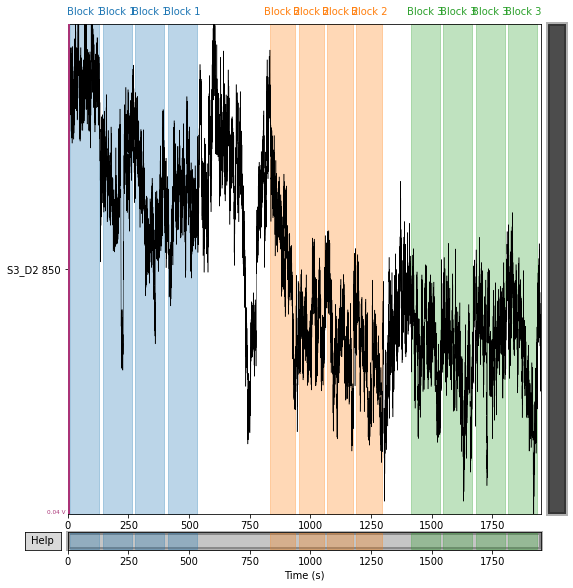

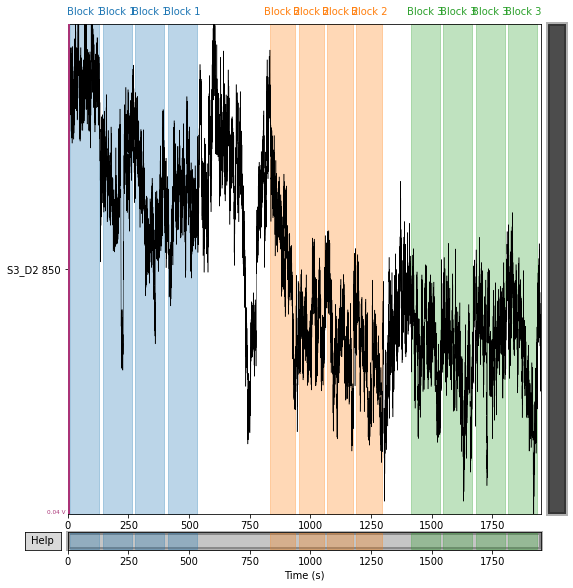

In [32]:
scans[10][1].copy().pick(['S3_D2 850']).plot(duration=2200)

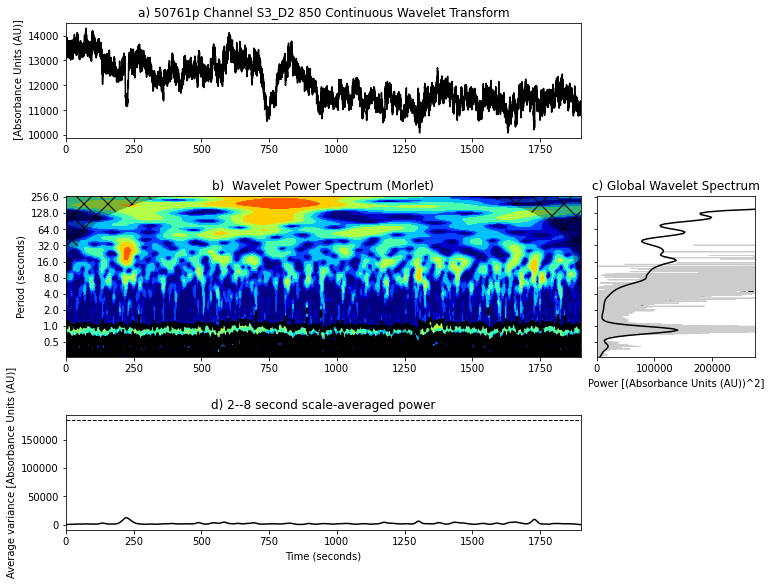

In [34]:
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    scans[10][1].copy().crop(tmax=1900),
    plot=True,
    chs=['S3_D2 850']
)

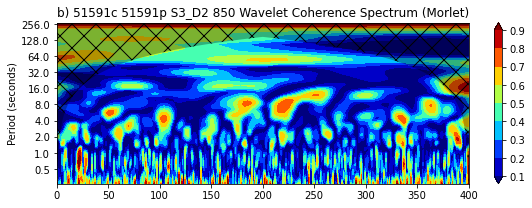

In [157]:
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    scans[4][0].copy().pick(['S3_D2 850']).crop(tmax=400),
    scans[4][1].copy().pick(['S3_D2 850']).crop(tmax=400),
    plot=True)

# Preprocessing Step

Now that data are loaded in and events are correctly distinct, we iterate through each dyad and each individual scan to apply LCBD-standard preprocessing functions. 
- Convert to Optical Density
- Record Scalp-Coupling Index and Mark Channels < 0.5
- Temporal Derivative Distribution Repair
- Beer Lambert Law to Convert to Haemoglobin
- Bandpass Filter 0.01-0.5 Hz

and append those dyads to a list of preprocessed scans. 

In [35]:
pps = []

# for each dyad scan in scans
for dscan in scans:

    ppdscan = []
    
    # individually preprocess each subject in dyad
    for scan in dscan:
        
        # convert to optical density
        raw_od = mne.preprocessing.nirs.optical_density(scan)

        # scalp coupling index
        sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
        raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
        
        # linear detrend, par example
#         raw.data[:] = scipy.signal.detrend(raw.get_data(), axis=-1, fit='linear')

        if len(raw_od.info['bads']) > 0:
            print("Bad channels in subject", raw_od.info['subject_info']['his_id'], ":", raw_od.info['bads'])
        
        # temporal derivative distribution repair (motion attempt)
        tddr_od = mne.preprocessing.nirs.tddr(raw_od)
#         print("tddr")
#         tddr_od.plot(
#             n_channels=len(tddr_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)
        
        # savgol filter (linear polynomial smoothing)
#         sav_od = raw_od.savgol_filter(0.5)
#         print("savgol filtering")
#         sav_od.plot(
#             n_channels=len(sav_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)

        bp_od = tddr_od.filter(0.01, 0.5)
#         print("bandpass")
#         bp_od.plot(
#             n_channels=len(bp_od.ch_names),
#             duration=100,
#             scalings=0.1,
#             show_scrollbars=False)
    
        # haemoglobin conversion
        haemo = mne.preprocessing.nirs.beer_lambert_law(bp_od, ppf=0.1)
#         print("haemo")
#         haemo.plot(
#             n_channels=len(haemo.ch_names),
#             duration=100,
#             scalings=0.0001,
#             show_scrollbars=False)

#         print("PSD")
#         haemo_lp.plot_psd(average=True)
        
        ppdscan.append(haemo)
        
    pps.append(ppdscan)

Bad channels in subject 50231p : ['S7_D3 760', 'S7_D3 850']
Bad channels in subject 51011c : ['S2_D2 760', 'S2_D2 850']
Bad channels in subject 50121c : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 50221p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 51431p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 50761p : ['S2_D2 760', 'S2_D2 850']
Bad channels in subject 51091c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51491p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 51422c : ['S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850']
Bad channels in subject 51422p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850', 'S6_D3 760', 'S6_D3 850', 'S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 50491p : ['S

<ipython-input-35-aefa1a4cb158>:12: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)


Bad channels in subject 51391c : ['S5_D3 760', 'S5_D3 850']


<ipython-input-35-aefa1a4cb158>:12: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)


Bad channels in subject 50521c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51281c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51281p : ['S5_D3 760', 'S5_D3 850', 'S6_D3 760', 'S6_D3 850']
Bad channels in subject 50802p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 50971c : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 50971p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850']
Bad channels in subject 51301c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51301p : ['S6_D3 760', 'S6_D3 850']
Bad channels in subject 51381c : ['S5_D3 760', 'S5_D3 850']
Bad channels in subject 51381p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 50321c : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 50801p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 51411p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 50111p : ['S1_D1 760', 'S1_D1 850', 'S2_

<ipython-input-35-aefa1a4cb158>:12: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)
<ipython-input-35-aefa1a4cb158>:12: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(scan)


Bad channels in subject 50591p : ['S1_D1 760', 'S1_D1 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 51421c : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 51421p : ['S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S6_D3 760', 'S6_D3 850', 'S7_D3 760', 'S7_D3 850', 'S7_D4 760', 'S7_D4 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 50992c : ['S2_D2 760', 'S2_D2 850']


In [ ]:
sampling_rate = pps[0][0].info['sfreq']
print(sampling_rate)

In [ ]:
# import matplotlib
# import matplotlib.pyplot as plt
# import mne
# import numpy as np
# import sys
# from typing import Union
# import math

# if not sys.warnoptions:
#     import warnings
#     warnings.filterwarnings("ignore")

    
# def xwt(sig1: mne.Epochs, sig2: mne.Epochs, sfreq: Union[int, float],
#         freqs: Union[int, np.ndarray], analysis: str) -> np.ndarray:
#     """
#     Perfroms a cross wavelet transform on two signals.
#     Arguments:
#         sig1 : mne.Epochs
#             Signal (eg. EEG data) of first participant.
#         sig2 : mne.Epochs
#             Signal (eg. EEG data) of second participant.
#         sfreq: int | float
#             Sampling frequency of the data in Hz.
#         freqs: int | float
#             Range of frequencies of interest in Hz.
#         analysis: str
#             Sets the type of analyses
#     Note:
#         This function relies on MNE's mne.time_frequency.morlet
#         and mne.time_frequency.tfr.cwt functions.
#     Returns:
#         cross_sigs, wtc:
#        -cross_sigs: the crosswavelet transform results
#        -wtc: wavelet transform coherence calculated according to
#         Maraun & Kurths (2004)
#     """

#     # Set the mother wavelet
#     Ws = mne.time_frequency.tfr.morlet(sfreq, freqs, n_cycles=6.0, sigma=None,
#                                        zero_mean=True)

#     # Set parameters for the output
#     n_freqs = len(freqs)
#     n_epochs, n_chans, n_samples = sig1.get_data().shape
#     n_epochs = min([sig1.get_data().shape[0], sig2.get_data().shape[0]])
#     cross_sigs = np.zeros(
#         (n_chans, n_epochs, n_freqs, n_samples),
#         dtype=complex) * np.nan
#     time = sig1.times[-1] - sig1.times[0]
    
#     # get cone of influence
#     dt = 1/sfreq
#     coi = []
#     for f in freqs:
#         dt_f = 1/f
#         f_coi_init = math.sqrt(2*2*dt_f)
#         f_coi = f_coi_init/dt
#         coi.append(f_coi)
        
#     coi_index = np.arange(0, len(freqs))
        
#     rev_coi = []
#     for f in freqs:
#         dt_f = 1/f
#         f_coi = math.sqrt(2*2*dt_f)
#         sub_max = (time-f_coi)/dt
#         rev_coi.append(sub_max)
    
#     # perform a continuous wavelet transform on all epochs of each signal
#     for ind, ch_label in enumerate(sig1.ch_names):

#         # Check the channels are the same between participants
#         assert sig2.ch_names[ind] == ch_label

#         # Extract the channel's data for both participants and apply cwt
# #         cur_sig1 = np.expand_dims(np.average(
# #             np.squeeze(sig1.get_data(mne.pick_channels(sig1.ch_names,
# #                 [ch_label]))),
# #             axis=0),
# #             0)
#         cur_sig1 = np.squeeze(sig1.get_data(mne.pick_channels(sig1.ch_names,
#                                                              [ch_label])))[:n_epochs, :]
#         out1 = mne.time_frequency.tfr.cwt(cur_sig1, Ws, use_fft=True,
#                                           mode='same', decim=1)

# #         cur_sig2 = np.expand_dims(np.average(
# #             np.squeeze(sig2.get_data(mne.pick_channels(sig2.ch_names,
# #                 [ch_label]))),
# #             axis=0),
# #             0)
#         cur_sig2 = np.squeeze(sig2.get_data(mne.pick_channels(sig2.ch_names,
#                                                              [ch_label])))[:n_epochs, :]
#         out2 = mne.time_frequency.tfr.cwt(cur_sig2, Ws, use_fft=True,
#                                           mode='same', decim=1)

#         # Perfrom the cross wavelet transform
#         tfr_cwt1 = out1.mean(0)
#         tfr_cwt2 = out2.mean(0)
#         wps1 = tfr_cwt1 * tfr_cwt1.conj()
#         wps2 = tfr_cwt2 * tfr_cwt2.conj()
#         cross_sigs = (out1 * out2.conj()).mean(0)
#         coh = (cross_sigs) / (np.sqrt(wps1*wps2))
#         abs_coh = np.abs(coh)
#         wct = (abs_coh - np.min(abs_coh)) / (np.max(abs_coh) - np.min(abs_coh))

#         if analysis == 'power':
#             data = np.abs((cross_sigs[:, :]))
#             data = data

#         elif analysis == 'phase':
#             data = np.angle(cross_sigs[:, :])

#         elif analysis == 'wtc':
#             data = wct
#             # make 0 / N/A outside COI
# #             weights = np.ones(data.shape)
#             grid = np.ogrid[0:data.shape[0], 0:data.shape[1]]
#             for i in grid[0]:
#                 for j in grid[1][0]:
#                     if (j < coi[i[0]]) or (j > rev_coi[i[0]]):
#                         data[i[0]][j] = np.nan
# #             data = data * weights
                        

#         elif analysis == 'xwt':
#             data = cross_sigs

#         else:
#             data = 'Please specify analysis'
#             print(data)
#         return data
    

# def half_wave(sfreq: Union[int, float], freqs: Union[int, np.ndarray], n_cycles: int = 6.0,
#               sigma: float = None, zero_mean: bool = True) -> tuple:
#     """
#     Calculates the minimum and maximum half-wavelength of each wavelet, so
#     that the area outside of the cone of influence is excluded
#     due to the edge effects created by zero padding.
#     Arguments:
#         sfreq: sampling frequency
#         freqs: ranges of frequencies of interest in Hz
#         n_cycles: number of cycles of the morelet wavelet (default is 6.0)
#         sigma: Controls the width of the wavelet (i.e. temporal resolution.)
#         If sigma is None the temporal resolution is adapted with the frequency
#         like for all wavelet transform.
#         The higher the frequency the shorter is the wavelet.
#         If sigma is fixed the temporal resolution is fixed
#         like for the short time Fourier transform
#         and the number of oscillations
#         increases with the frequency (default is None).
#         zero_mean: If True, the wavelet has a mean of zero (default is True)
#     Note:
#         This function relies on MNE's mne.time_frequency.morlet function.
#      Returns:
#         max_half_wave, min_half_wave: The maximum and minimum half wave lengths
#         that specify the bounds of the cone of influence
#     """
#     Wave = mne.time_frequency.tfr.morlet(sfreq, freqs, n_cycles,
#                                          sigma, zero_mean)

#     min_half_wave = []
#     max_half_wave = []

#     for number in Wave:
#         min_half_wave.append(len(number) / 2)

#     for wl in min_half_wave:
#         max_wl = sfreq - wl
#         max_half_wave.append(max_wl)

#     return min_half_wave, max_half_wave

# def COIError():
#     """
#     Called by the xwt, phase, and wtc plotting functions to display an Error
#     message if all data falls within COI.
#     Indicates that time span of data is too short for analysis.
#     Arguments:
#         None
#     Returns:
#         str: COI ERROR message
#     """
#     return 'ERROR: INVALID WT. All results are within COI.'


# def plot_wt(sig1: mne.Epochs,
#             sfreq: Union[int, float],
#             freqs: Union[int, float, np.ndarray],
#             time: int, figsize: tuple = (30, 8),
#             tmin: int = 0, x_units: Union[int, float] = 100):
#     """
#     Plots the results of the wavelet transform.
#     Arguments:
#          sig1 : mne.Epochs
#             Signal (eg. EEG data) of first participant.
#         freqs: int | float | np.ndarray
#             Frequency range of interest in Hz.
#         time: int
#             Time of sample duration in seconds.
#         figsize: tuple
#             Figure size (default is (30, 8)).
#         xmin: int
#             Minimum x-value (default is 0).
#         x_units: int | float
#             distance between xticks on x-axis (time) (default is 100)
#     Returns:
#     Figure of wavelet transform results.
#     """  
#     dt = 1/sfreq
#     xmax = time/dt
#     xmin = tmin * dt
#     tick_units = xmax/x_units
#     unit_conv = time/x_units
#     xticks = np.arange(xmin, xmax, tick_units)
#     x_labels = np.arange(tmin, time, unit_conv)
#     xmark = []
#     for xlabel in x_labels:
#         if xlabel != '':
#             mark = str(round(xlabel, 3))
#             xmark.append(mark)
#         else:
#             xmark = xlabel

#     coi = []
#     for f in freqs:
#         dt_f = 1/f
#         f_coi_init = math.sqrt(2*2*dt_f)
#         f_coi = f_coi_init/dt
#         coi.append(f_coi)

#     coi_check = []
#     for item in coi:
#         if item >= (time/dt):
#             coi_check.append(False)
#         else:
#             coi_check.append(True)

#     if False in coi_check:
#         print(COIError())
#     else:
#         print('Time window appropriate for wavelet transform')

#     coi_index = np.arange(0, len(freqs))

#     rev_coi = []
#     for f in freqs:
#         dt_f = 1/f
#         f_coi = math.sqrt(2*2*dt_f)
#         sub_max = (time-f_coi)/dt
#         rev_coi.append(sub_max)
    
#     wt = mne.time_frequency.tfr_array_morlet(
#         sig1.get_data(),
#         sfreq,
#         freqs,
#         output='avg_power')
#     wt = np.squeeze(wt)
# #     wt = np.squeeze(np.average(wt, axis=0))
#     data = wt

#     fig = plt.figure(figsize=figsize)
#     plt.subplot(122)

#     analysis_title = 'Wavelet Transform'
#     cbar_title = 'Power'
#     my_cm = matplotlib.cm.get_cmap('plasma')
#     plt.imshow(data, aspect='auto', cmap=my_cm, interpolation='lanczos')
    
#     plt.gca().invert_yaxis()
#     plt.ylabel('Frequencies (Hz)')
#     plt.xlabel('Time (s)')
#     ylabels = np.linspace((freqs[0]), (freqs[-1]), len(freqs[0:]))
#     ymark = []
#     for ylabel in ylabels:
#         if ylabel != '':
#             mark = str(round(ylabel, 3))
#             ymark.append(mark)
#         else:
#             ymark = ylabel

#     plt.gca().set_yticks(ticks=np.arange(0, len(ylabels)), labels=ymark)
#     plt.gca().set_xticks(ticks=xticks, labels=xmark)
#     plt.xlim(tmin, xmax)
#     plt.ylim(0, int(len(ylabels[0:-1])))
#     plt.plot(coi, coi_index, 'w')
#     plt.plot(rev_coi, coi_index, 'w')

#     plt.fill_between(coi, coi_index, hatch='X', fc='w', alpha=0.5)
#     plt.fill_between(rev_coi, coi_index, hatch='X', fc='w', alpha=0.5)

#     plt.axvspan(xmin, min(coi), hatch='X', fc='w', alpha=0.5)
#     plt.axvspan(xmax, max(rev_coi), hatch='X', fc='w', alpha=0.5)

#     plt.title(analysis_title)
#     plt.colorbar(label=cbar_title)

#     return 


# def plot_xwt(sig1: mne.Epochs, sig2: mne.Epochs,
#              sfreq: Union[int, float],
#              freqs: Union[int, float, np.ndarray],
#              time: int, analysis: str,
#              figsize: tuple = (30, 8), tmin: int = 0,
#              x_units: Union[int, float] = 100):
#     """
#     Plots the results of the Cross wavelet analysis.
#     Arguments:
#          sig1 : mne.Epochs
#             Signal (eg. EEG data) of first participant.
#         sig2 : mne.Epochs
#             Signal (eg. EEG data) of second participant.
#         freqs: int | float | np.ndarray
#             Frequency range of interest in Hz.
#         time: int
#             Time of sample duration in seconds.
#         analysis: str
#             Sets type of analysis.
#         figsize: tuple
#             Figure size (default is (30, 8)).
#         xmin: int
#             Minimum x-value (default is 0).
#         x_units: int | float
#             distance between xticks on x-axis (time) (default is 100)
#     Note:
#         This function is not meant to be called indepedently,
#         but is meant to be called when using plot_xwt_crosspower
#         or plot_xwt_phase_angle.
#     Returns:
#     Figure of xwt results.
#     """

#     dt = 1/sfreq
#     xmax = time/dt
#     xmin = tmin * dt
#     tick_units = xmax/x_units
#     unit_conv = time/x_units
#     xticks = np.arange(xmin, xmax, tick_units)
#     x_labels = np.arange(tmin, time, unit_conv)
#     xmark = []
#     for xlabel in x_labels:
#         if xlabel != '':
#             mark = str(round(xlabel, 3))
#             xmark.append(mark)
#         else:
#             xmark = xlabel

#     coi = []
#     for f in freqs:
#         dt_f = 1/f
#         f_coi_init = math.sqrt(2*2*dt_f)
#         f_coi = f_coi_init/dt
#         coi.append(f_coi)

#     coi_check = []
#     for item in coi:
#         if item >= (time/dt):
#             coi_check.append(False)
#         else:
#             coi_check.append(True)

#     if False in coi_check:
#         print(COIError())
#     else:
#         print('Time window appropriate for wavelet transform')

#     coi_index = np.arange(0, len(freqs))

#     rev_coi = []
#     for f in freqs:
#         dt_f = 1/f
#         f_coi = math.sqrt(2*2*dt_f)
#         sub_max = (time-f_coi)/dt
#         rev_coi.append(sub_max)

#     fig = plt.figure(figsize=figsize)
#     plt.subplot(122)

#     if analysis == 'phase':
#         data = xwt(sig1, sig2, sfreq, freqs, analysis='phase')
#         analysis_title = 'Cross Wavelet Transform (Phase Angle)'
#         cbar_title = 'Phase Difference'
#         my_cm = matplotlib.cm.get_cmap('hsv')
#         plt.imshow(data, aspect='auto', cmap=my_cm, interpolation='nearest')

#     elif analysis == 'power':
#         data = xwt(sig1, sig2, sfreq, freqs, analysis='power')
#         normed_data = (data - np.min(data)) / (np.max(data) - np.min(data))
#         analysis_title = 'Cross Wavelet Transform (Power)'
#         cbar_title = 'Cross Power'
#         my_cm = matplotlib.cm.get_cmap('viridis')
#         plt.imshow(normed_data, aspect='auto', cmap=my_cm,
#                    interpolation='lanczos')

#     elif analysis == 'wtc':
#         data = xwt(sig1, sig2, sfreq, freqs, analysis='wtc')
#         analysis_title = 'Wavelet Coherence'
#         cbar_title = 'Coherence'
#         my_cm = matplotlib.cm.get_cmap('plasma')
#         plt.imshow(data, aspect='auto', cmap=my_cm, interpolation='lanczos')

#     else:
#         ValueError('Analysis must be set as phase, power, or wtc.')

#     plt.gca().invert_yaxis()
#     plt.ylabel('Frequencies (Hz)')
#     plt.xlabel('Time (s)')
#     ylabels = np.linspace((freqs[0]), (freqs[-1]), len(freqs[0:]))
#     ymark = []
#     for ylabel in ylabels:
#         if ylabel != '':
#             mark = str(round(ylabel, 3))
#             ymark.append(mark)
#         else:
#             ymark = ylabel

#     plt.gca().set_yticks(ticks=np.arange(0, len(ylabels)), labels=ymark)
#     plt.gca().set_xticks(ticks=xticks, labels=xmark)
#     plt.xlim(tmin, xmax)
#     plt.ylim(0, int(len(ylabels[0:-1])))
#     plt.plot(coi, coi_index, 'w')
#     plt.plot(rev_coi, coi_index, 'w')

#     plt.fill_between(coi, coi_index, hatch='X', fc='w', alpha=0.5)
#     plt.fill_between(rev_coi, coi_index, hatch='X', fc='w', alpha=0.5)

#     plt.axvspan(xmin, min(coi), hatch='X', fc='w', alpha=0.5)
#     plt.axvspan(xmax, max(rev_coi), hatch='X', fc='w', alpha=0.5)

#     plt.title(analysis_title)
#     plt.colorbar(label=cbar_title)

#     return 

In [ ]:
# sig1: mne.Epochs,
#             sfreq: Union[int, float],
#             freqs: Union[int, float, np.ndarray],
#             time: int, analysis: str,
#             figsize: tuple = (30, 8), tmin: int = 0,
#             x_units: Union[int, float] = 100):
                    
# epoch = scans[10][0].copy().pick(['S3_D2 850'])
# sfreq = epoch.info['sfreq']
# freqs = 1/np.flip(2 ** np.arange(-2, 9, dtype=float))
# time = epoch.times[-1]

# plot_wt(
#     scans[10][0],
#     sfreq=sfreq,
#     freqs=freqs,
#     time=time,
#     x_units=10)

In [37]:
epoch_df = {}

for dscan in pps:
    
    for scan in dscan:
    
        epoch_df[scan.info['subject_info']['his_id']] = {}
    
#         for i, ROI in enumerate(ROIs.keys()):
        for i, ROI in enumerate([ch for ch in scan.info['ch_names'] if "hbo" in ch]):
            
            epoch_df[scan.info['subject_info']['his_id']][ROI] = []
        
            events, event_dict = mne.events_from_annotations(dscan[0], verbose=False)
            reject_criteria = dict(hbo=200e-6)
            tmin, puzzletmax, playtmax = -5, 105, 120
            
            preplay_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[0]: list(event_dict.values())[0]},
                tmin=tmin,
                tmax=playtmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(preplay_epochs)
            
            puzzle_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[1]: list(event_dict.values())[1]},
                tmin=tmin,
                tmax=puzzletmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(puzzle_epochs)
            
            postplay_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[2]: list(event_dict.values())[2]},
                tmin=tmin,
                tmax=playtmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(postplay_epochs)

In [39]:
epoch_df['50531c']['S1_D1 hbo']

[<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 1': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 2': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 3': 4>]

In [40]:
event_dict

{'Block 1': 1, 'Block 2': 2, 'Block 3': 3}

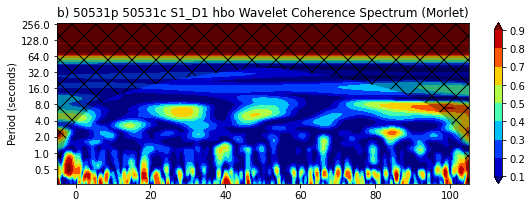

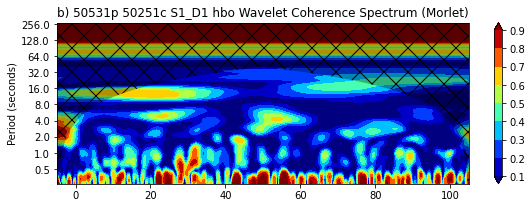

In [41]:
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['50531p']['S1_D1 hbo'][1][0].copy(),
    epoch_df['50531c']['S1_D1 hbo'][1][0].copy(),
    plot=True)

WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['50531p']['S1_D1 hbo'][1][0].copy(),
    epoch_df['50251c']['S1_D1 hbo'][1][0].copy(),
    plot=True)

In [42]:
epoch_df.keys()

dict_keys(['50231c', '50231p', '50631c', '50631p', '50601c', '50601p', '51131c', '51131p', '51011c', '51011p', '50552c', '50552p', '50121c', '50121p', '50221c', '50221p', '51431c', '51431p', '50322c', '50322p', '50761c', '50761p', '50092c', '50092p', '51091c', '51091p', '50331c', '50331p', '51211c', '51211p', '51491c', '51491p', '51422c', '51422p', '50832c', '50832p', '50431c', '50431p', '50081c', '50081p', '50911c', '50911p', '50281c', '50281p', '50421c', '50421p', '51571c', '51571p', '50491c', '50491p', '50342c', '50342p', '51041c', '51041p', '50032c', '50032p', '51591c', '51591p', '51501c', '51501p', '51471c', '51471p', '50211c', '50211p', '51212c', '51212p', '50621c', '50621p', '50191c', '50191p', '50721c', '50721p', '51221c', '51221p', '50551c', '50551p', '51231c', '51231p', '50841c', '50841p', '50021c', '50021p', '50501c', '50501p', '51021c', '51021p', '51441c', '51441p', '51181c', '51181p', '50891c', '50891p', '51341c', '51341p', '50981c', '50981p', '50391c', '50391p', '50961c',

In [29]:
del scans
del pps.

In [30]:
import random

In [31]:
sync_df = {}
block_types = ['Block 1', 'Block 2', 'Block 3']

# for every parent subject
for parent in [sub for sub in sorted(epoch_df.keys()) if "p" in sub]:
    sync_df[parent] = {}
    
    # pick two children, one real and one random
    children = [parent.replace("p", "c")]
    children.append(
        random.choice([sub for sub in epoch_df.keys() if "c" in sub \
            and parent.replace("p", "") not in sub]))
    
    # for every child subject
#     for child in [sub for sub in sorted(epoch_df.keys()) if "c" in sub]:
    for child in children:
        sync_df[parent][child] = {}
        
        # for every block type (pre-play, puzzle, post-play)
        for block_num, block in enumerate(block_types):
            
            sync_df[parent][child][block] = {}
                
            # for each channel available with this sub
            for ch in epoch_df[parent].keys():
                
                # our sync value is going to go here
                # sync_df[parent][child][block][ch]
                # i.e. averaging over block iterations
                
                # so start keeping track of average
                pc_wcts = []
                
                p_epoch = epoch_df[parent][ch][block_num].load_data()
                c_epoch = epoch_df[child][ch][block_num].load_data()
                
                # for each iteration of this block (max 4)
                for block_it in np.arange(0, np.min([
                    len(p_epoch),
                    len(c_epoch)])):
                    
                    try:
                        WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
                            p_epoch[block_it],
                            c_epoch[block_it],
                            plot=True if "S5_D3" in ch else False,
                            fig_fname=f"/data/perlman/moochie/analysis/CARE/sync_figs/{parent}_{child}_{ch.replace(' ', '_')}_{block_num}_{block_it}.png")

                        # make values outside COI = np.nan
                        nanWCT = WCT
                        for t in range(nanWCT.shape[1]):
                            nanWCT[np.where(freqs>coi[t]), t] = np.nan
                        # also set to nan outside frequencies of interest
                        # periods == 2s to 20s
                        
                        # TASK RELATED FREQUENCIES ARE ARBITRARILY DETERMINED right here
                        WCT[(2>(1/freqs))|((1/freqs)>20), :] = np.nan

                        # average inside cone of influence
                        # of values from freq range [0.5, ]
                        pc_wcts.append(np.nanmean(nanWCT))
    #                     print(np.nanmean(nanWCT))
    
                    except:
                        print(f"Fail @ parent {parent}, child {child}, block {block}, channel {ch}, block it {block_it}")
#                 print(np.average(pc_wcts))  
                sync_df[parent][child][block][ch] = np.average(pc_wcts)

In [33]:
# sync_df

In [32]:
# SAVE SYNCHRONY VALUES

import json
json_object = json.dumps(sync_df, indent=4)

with open("/data/perlman/moochie/analysis/CARE/wct_small_2.json", 'w') as outfile:
    json.dump(sync_df, outfile)

In [44]:
# LOAD SYNCHRONY VALUES

import json
with open("/data/perlman/moochie/analysis/CARE/wct_small_2.json", 'r') as infile:
    sync_df = json.load(infile)

In [45]:
len(sync_df.keys())

129

In [46]:
len(set([sub[:-2] for sub in list(sync_df.keys())]))

107

In [51]:
# sync_df

In [48]:
dyad_b1 = []
nyad_b1 = []

for parent in sync_df.keys():
    for ch in list(sync_df[parent][list(sync_df[parent].keys())[0]]['Block 2'].keys()):
        dyad_b1.append(
            sync_df[parent][list(sync_df[parent].keys())[0]]['Block 2'][ch])
    for ch in list(sync_df[parent][list(sync_df[parent].keys())[1]]['Block 2'].keys()):
        nyad_b1.append(
            sync_df[parent][list(sync_df[parent].keys())[1]]['Block 2'][ch])

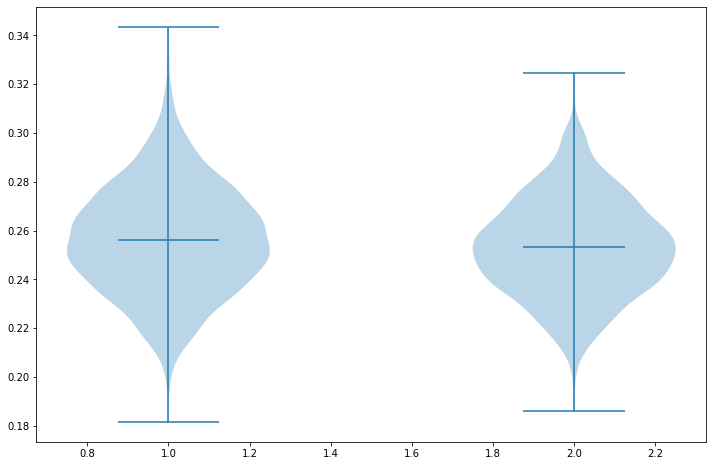

In [52]:
plt.clf()
plt.violinplot(
    [dyad_b1, nyad_b1],
    showmeans=True,
#     showmedians=True,
)
plt.show()

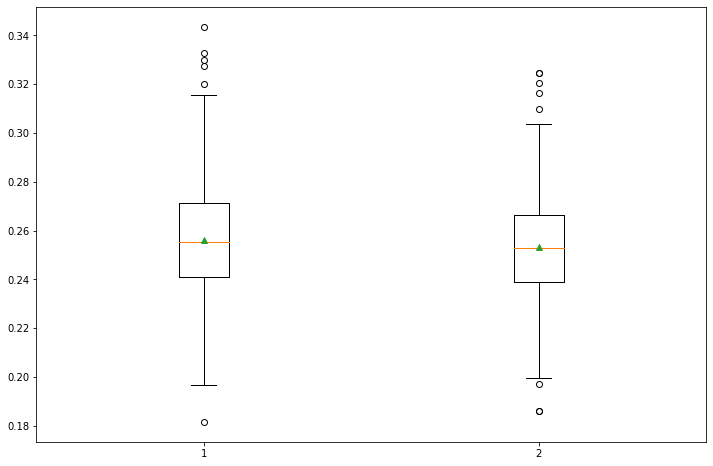

In [53]:
plt.boxplot(
    [dyad_b1, nyad_b1],
    showmeans=True,
#     showmedians=True,
)
plt.show()

In [54]:
from scipy.stats import ttest_ind

In [55]:
statistic, pvalue = ttest_ind(
    dyad_b1,
    nyad_b1)

In [57]:
statistic

3.7314706124148995

In [56]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.00019447633991549087


In [58]:
groups = pd.read_csv("/data/perlman/moochie/analysis/CARE/forperlman_rdaslist_20221101.csv")
groups['subject'] = [id.replace('-', '') for id in groups['record_id']]
groups.set_index('subject', inplace=True)

In [59]:
groups

,famid,record_id,rdas_group,enroll_group
subject,,,,
50001,5000,5000-1,Conflict,Divorce
50021,5002,5002-1,Non-Conflict,Control
50031,5003,5003-1,Non-Conflict,Control
50032,5003,5003-2,Non-Conflict,Control
50071,5007,5007-1,Non-Conflict,Control
...,...,...,...,...
51511,5151,5151-1,Conflict,Divorce
51521,5152,5152-1,Non-Conflict,Control
51531,5153,5153-1,Conflict,Divorce


In [60]:
scores = pd.read_csv("/data/perlman/moochie/analysis/CARE/forkhalil_fullscored.csv")
scores['subject'] = [id.replace('-', '') for id in scores['record_id']]
scores.set_index('subject', inplace=True)
scores.drop(columns=['record_id'], inplace=True)
scores = scores.astype({'famid': 'str'})

In [62]:
scores

,famid,subid,consensus,satisfaction,cohesion,total
subject,,,,,,
50021,5002,1,27,17,13,57
50091,5009,1,29,20,15,64
50092,5009,2,29,20,15,64
50111,5011,1,25,18,11,54
50181,5018,1,29,17,15,61
...,...,...,...,...,...,...
51431,5143,1,18,9,15,42
51441,5144,1,11,3,4,18
51471,5147,1,20,14,11,45


In [72]:
scores.columns

Index(['famid', 'subid', 'consensus', 'satisfaction', 'cohesion', 'total'], dtype='object')

In [73]:
len([id for id in scores.index])

112

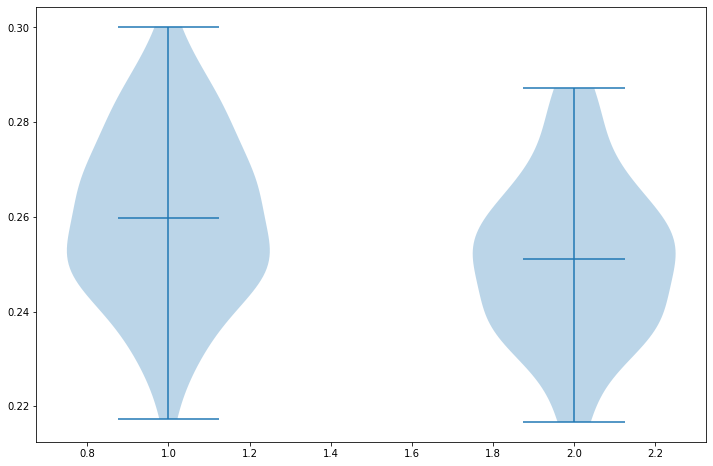

T stat: 2.7066014063581245 
 P value: 0.007732759681705392


In [74]:
group1syncs = []
group2syncs = []

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

for sub in sync_df.keys():
    avgsync = np.average([
        sync_df[sub][sub.replace('p', 'c')]['Block 2'][ch] for ch in channels])
    
    if (groups.loc[[sub.replace('p', '')]]['enroll_group'][0] == "Control") and \
        (groups.loc[[sub.replace('p', '')]]['rdas_group'][0] == "Non-Conflict"):
        group1syncs.append(avgsync)
    else:
        group2syncs.append(avgsync)
        
plt.clf()
plt.violinplot(
    [group1syncs, group2syncs],
    showmeans=True)
plt.show()

statistic, pvalue = ttest_ind(
    group1syncs,
    group2syncs)

print("T stat:", statistic, "\n", "P value:", pvalue)

In [75]:
np.std(group2syncs)

0.016444974052242916

In [76]:
# enrollment group 2 OR above RDAS critical value == conflict group

In [77]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

In [78]:
blocks = {
    'Block 1': 'Pre-Play',
    'Block 2': 'Puzzle',
    'Block 3': 'Post-Play',
}

COIs = [
    'consensus',
    'satisfaction',
    'cohesion',
#     'total'
]

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

In [79]:
list(sync_df.keys())[0]

'50001p'

In [82]:
# for block_num in blocks.keys():
#     block_name = blocks[block_num]

#     syncs = [np.average([
#     #     (sync_df[parent][parent.replace('p', 'c')]['Block 2'][ch] - sync_df[parent][parent.replace('p', 'c')]['Block 1'][ch]) \
#         sync_df[parent][parent.replace('p', 'c')][block_num][ch] \
#             for ch in channels]) for parent in sync_df.keys() \
#                 if parent.replace('p', '')[:-1] in list(scores['famid'])]
    
#     for COI in COIs:
        
# #         rdas = [scores.loc[[sub]][COI][0] for sub in [sub.replace('p', '') for sub in sync_df.keys() \
# #             if sub.replace('p', '')[:-1] in list(scores['fam_id'])]]
        
#         rdas = []
#         for sub in sync_df.keys():
#             if sub.replace('p', '')[:-1] in list(scores['famid']):
#                 rdas.append(
#                     scores[scores['famid'] == sub.replace('p', '')[:-1]][COI][0])
#             else:
# #                 rdas.append(np.nan)
#                 print("No RDAS data for:", sub)
#                 print("Group:", groups[sub.replace('p', '')])

#         xnan = np.array(rdas, dtype='float')
#         ynan = np.array(syncs, dtype='float')
        
# #         # get IQR
# #         q75, q25 = np.percentile(xnan, [75, 25])
# #         intr_qr = q75 - q25
# #         qmax = q75 + (1.5 * intr_qr)
# #         qmin = q25 - (1.5 * intr_qr)
        
# #         # remove the extra-IQR vals
# #         xnan[xnan < qmin] = qmin
# #         xnan[xnan > qmax] = qmin


    
#         x = np.delete(xnan, np.where(np.isnan(xnan)))
#         y = np.delete(ynan, np.where(np.isnan(xnan)))
        
#         print("x shape:", x.shape)
#         print("y shape:", y.shape)
        
#         # winsorize(y, inplace=True, limits=[0.05, 0.05])
#         # winsorize(x, inplace=True, limits=[0.05, 0.05])
        
#         X = x
#         Y = y
        
#         x = x.reshape(-1, 1)

#         model = LinearRegression().fit(x, y)
        
#         r_sq = model.score(x, y)
#         print(f"Coefficient of Determination: {r_sq}")
#         print(f"intercept: {model.intercept_}")
#         print(f"slope: {model.coef_}")
        
#         plt.clf()
#         # plot data
#         plt.scatter(
#             x,
#             y,
#             color='black')
#         # plot regression line
#         plt.plot(
#             np.linspace(np.min(x), np.max(x)),
#             model.predict(np.linspace(np.min(x), np.max(x)).reshape(-1, 1)),
#             color='blue',
#             linewidth=3)
#         plt.xlabel(f"RDAS {COI.upper()}")
#         plt.ylabel(f"Dyadic Synchrony in {block_name}")
#         plt.title(f"{block_name}: {COI}")

#         plt.show()
# #         plt.savefig(
# #             f"/data/perlman/moochie/analysis/CARE/{block_name}_RDAS_{COI}.png",
# #             dpi=100)

#         X2 = sm.add_constant(X)
#         est = sm.OLS(Y, X2)
#         est2 = est.fit()
#         print(est2.summary())

Coefficient of Determination: 0.045943867613540634
intercept: 0.24335276267275804
slope: [0.00060838]


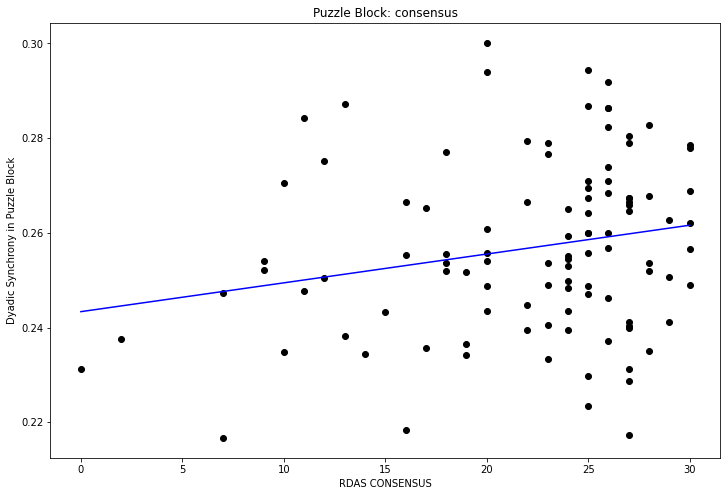

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.960
Date:                Tue, 08 Nov 2022   Prob (F-statistic):             0.0281
Time:                        11:33:21   Log-Likelihood:                 274.06
No. Observations:                 105   AIC:                            -544.1
Df Residuals:                     103   BIC:                            -538.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2434      0.006     38.765      0.0

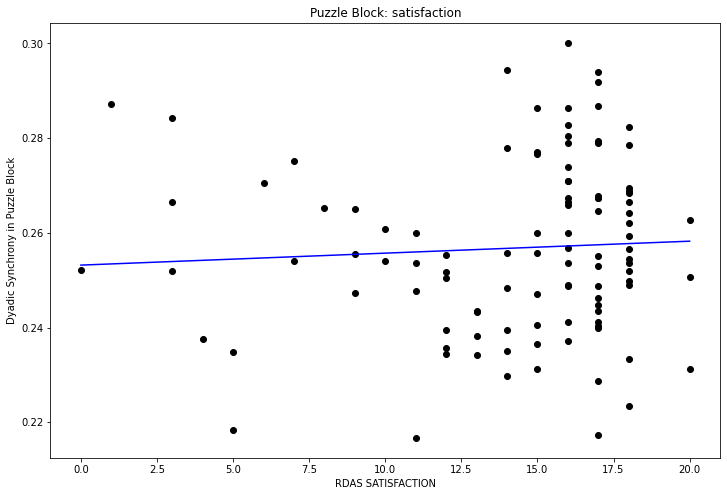

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.3781
Date:                Tue, 08 Nov 2022   Prob (F-statistic):              0.540
Time:                        11:33:21   Log-Likelihood:                 271.78
No. Observations:                 105   AIC:                            -539.6
Df Residuals:                     103   BIC:                            -534.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2532      0.006     41.390      0.0

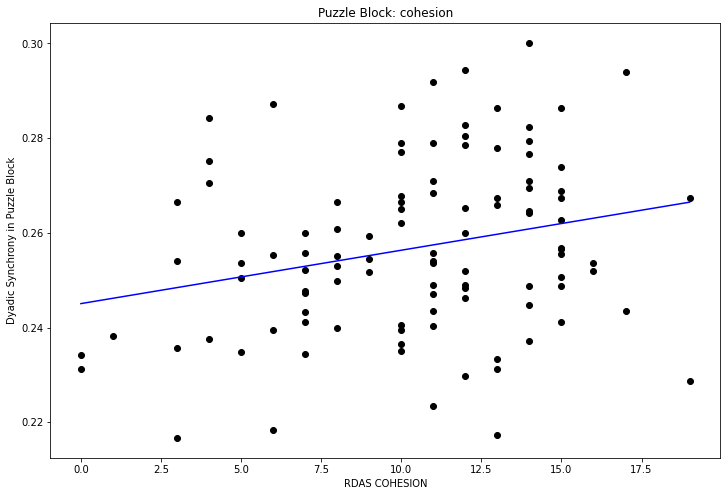

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     7.109
Date:                Tue, 08 Nov 2022   Prob (F-statistic):            0.00891
Time:                        11:33:21   Log-Likelihood:                 275.09
No. Observations:                 105   AIC:                            -546.2
Df Residuals:                     103   BIC:                            -540.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2451      0.005     51.826      0.0

In [81]:
# syncs = [
#     sync_df[parent][parent.replace('p', 'c')]['Block 3']['S7_D3 hbo'] - sync_df[parent][parent.replace('p', 'c')]['Block 1']['S7_D3 hbo'] \
#         for parent in list(sync_df.keys()) \
#             if parent.replace('p', '') in list(scores.index)]
channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

# block_num = 'Block 1'
block_name = 'Puzzle Block'

# syncs = [np.average([
#     list(sync_df[parent][parent.replace('p', 'c')][block_num][ch]) for ch in frontal_channels]) \
#         for parent in list(sync_df.keys()) \
#             if parent.replace('p', '') in list(scores.index)]

syncs = [np.average([
#     (sync_df[parent][parent.replace('p', 'c')]['Block 2'][ch] - sync_df[parent][parent.replace('p', 'c')]['Block 1'][ch]) \
    sync_df[parent][parent.replace('p', 'c')]['Block 2'][ch] \
        for ch in channels]) for parent in sync_df.keys() \
            if parent.replace('p', '') in list(scores.index)]

for COI in COIs:

    rdas = [scores.loc[[sub]][COI][0] for sub in [sub.replace('p', '') for sub in sync_df.keys() \
        if sub.replace('p', '') in list(scores.index)]]

    xnan = np.array(rdas, dtype='float')
    ynan = np.array(syncs, dtype='float')

#         # get IQR
#         q75, q25 = np.percentile(xnan, [75, 25])
#         intr_qr = q75 - q25
#         qmax = q75 + (1.5 * intr_qr)
#         qmin = q25 - (1.5 * intr_qr)

#         # remove the extra-IQR vals
#         xnan[xnan < qmin] = qmin
#         xnan[xnan > qmax] = qmin

    x = np.delete(xnan, np.where(np.isnan(xnan)))
    y = np.delete(ynan, np.where(np.isnan(xnan)))

    # winsorize(y, inplace=True, limits=[0.05, 0.05])
    # winsorize(x, inplace=True, limits=[0.05, 0.05])

    X = x
    Y = y

    x = x.reshape(-1, 1)

    model = LinearRegression().fit(x, y)

    r_sq = model.score(x, y)
    print(f"Coefficient of Determination: {r_sq}")
    print(f"intercept: {model.intercept_}")
    print(f"slope: {model.coef_}")

    plt.clf()
    # plot data
    plt.scatter(
        x,
        y,
        color='black')
    # plot regression line
    plt.plot(
        np.linspace(np.min(x), np.max(x)),
        model.predict(np.linspace(np.min(x), np.max(x)).reshape(-1, 1)),
        color='blue',
        linewidth=1.5)
    plt.xlabel(f"RDAS {COI.upper()}")
    plt.ylabel(f"Dyadic Synchrony in {block_name}")
    plt.title(f"{block_name}: {COI}")

    plt.show()

    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    print(est2.summary())